In [11]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/kubig_financial/finrl")

## install required packages
!pip install gym
!pip install stockstats
!pip install gymnasium
!pip install stable_baselines3
!pip install alpaca_trade_api
!pip install exchange_calendars
!pip install pyfolio
!pip install matplotlib
!pip install swig
!pip install wrds
!pip install pyportfolioopt
!pip install --upgrade ipykernel
## install finrl library
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [15]:
def finrl_main(using='a2c', TRADE_END_DATE='2023-05-05', FORCAST_SIZE=30, epochs=200, tolerance=0.0001, hmax=10000, initial_amount=1000000):

  import sys
  sys.path.append("/content/drive/MyDrive/kubig_financial/finrl")

  import pandas as pd
  import numpy as np
  import matplotlib
  import matplotlib.pyplot as plt
  # matplotlib.use('Agg')
  import datetime

  %matplotlib inline
  from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
  from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
  from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
  from finrl.agents.stablebaselines3.models import DRLAgent
  from stable_baselines3.common.logger import configure
  from finrl.meta.data_processor import DataProcessor

  from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
  from pprint import pprint

  import itertools

  from finrl import config
  from finrl import config_tickers
  import os
  from finrl.main import check_and_make_directories
  from finrl.config import (
      DATA_SAVE_DIR,
      TRAINED_MODEL_DIR,
      TENSORBOARD_LOG_DIR,
      RESULTS_DIR,
      INDICATORS,
      TRAIN_START_DATE,
      TRAIN_END_DATE,
      TEST_START_DATE,
      TEST_END_DATE,
      TRADE_START_DATE,
      TRADE_END_DATE,
  )
  check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

  %cd /content/drive/MyDrive/kubig_financial
  !ls
  import dlinear_module

  ##### parameter inside #####
  TRAIN_START_DATE = '2010-01-01'
  TRAIN_END_DATE = '2021-10-01'
  TRADE_START_DATE = '2021-10-01'

  tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

  ## agent setting
  if_using_a2c = False
  if_using_ddpg = False
  if_using_ppo = False
  if_using_td3 = False
  if_using_sac = False

  if using == 'a2c':
    if_using_a2c = True
    using_stratgy = if_using_a2c
  elif using == 'ddpg':
    if_using_ddpg = True
    using_stratgy = if_using_ddpg
  elif using == 'ppo':
    if_using_ppo = True
    using_stratgy = if_using_ppo
  elif using == 'td3':
    if_using_td3 = True
    using_stratgy = if_using_td3
  elif using == 'sac':
    if_using_td3 = True
    using_stratgy = if_using_sac

  ############################

  ## data loading
  df = YahooDownloader(start_date = TRAIN_START_DATE, end_date = TRADE_END_DATE, ticker_list = tickers).fetch_data()
  df.sort_values(['date','tic'],ignore_index=True)

  ## load dlinear prediction
  prediction_5,prediction_10,prediction_30 = dlinear_module.main(FORCAST_SIZE, epochs, tolerance, TRADE_END_DATE)

  print(INDICATORS)
  ## feature Engineering
  fe = FeatureEngineer(use_technical_indicator=True,
                      tech_indicator_list = INDICATORS,
                      use_vix=True,
                      use_turbulence=True,
                      user_defined_feature = False)

  processed = fe.preprocess_data(df)
  processed.sort_values(['date','tic'],ignore_index=True)

  list_ticker = processed["tic"].unique().tolist() #ticker 리스트 불러오기
  list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str)) #전체 데이터 날짜 날짜 리스트
  combination = list(itertools.product(list_date,list_ticker)) #date, ticker 의 combination

  processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left") #date, tic combination 기준으로 우측에 해당되는 정보들 정리
  processed_full = processed_full[processed_full['date'].isin(processed['date'])]
  processed_full = processed_full.sort_values(['date','tic'])
  processed_full = processed_full.fillna(0)

  ## combine prediction
  prediction_5_list = []
  for i in range(len(prediction_5)):
      for j in range(len(tickers)):
          prediction_5_list.append(prediction_5.iloc[i,j])

  for i in range((len(processed_full)-len(prediction_5_list))//len(tickers)):
      for j in range(len(tickers)):
          prediction_5_list.append(prediction_5.iloc[-1,j])

  prediction_10_list = []
  for i in range(len(prediction_10)):
      for j in range(len(tickers)):
          prediction_10_list.append(prediction_10.iloc[i,j])

  for i in range((len(processed_full)-len(prediction_10_list))//len(tickers)):
      for j in range(len(tickers)):
          prediction_10_list.append(prediction_10.iloc[-1,j])

  prediction_30_list = []
  for i in range(len(prediction_30)):
      for j in range(len(tickers)):
          prediction_30_list.append(prediction_30.iloc[i,j])
  for i in range((len(processed_full)-len(prediction_30_list))//len(tickers)):
      for j in range(len(tickers)):
          prediction_30_list.append(prediction_30.iloc[-1,j])

  processed_full['prediction_5']=prediction_5_list
  processed_full['prediction_10']=prediction_10_list
  processed_full['prediction_30']=prediction_30_list

  INDICATORS += ['prediction_5','prediction_10','prediction_30']

  ## data split
  train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
  trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)

  stock_dimension = len(train.tic.unique())
  state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension #현재 상태를 나타내는 state를 정의. 1+ ticker 개수 x2 + 인디케이터 개수 x ticker개수
  print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

  buy_cost_list = sell_cost_list = [0.001] * stock_dimension
  num_stock_shares = [0] * stock_dimension

  env_kwargs = {
      "hmax": hmax,
      "initial_amount": initial_amount,
      "num_stock_shares": num_stock_shares,
      "buy_cost_pct": buy_cost_list,
      "sell_cost_pct": sell_cost_list,
      "state_space": state_space,
      "stock_dim": stock_dimension,
      "tech_indicator_list": INDICATORS,
      "action_space": stock_dimension,
      "reward_scaling": 1e-4
  }

  e_train_gym = StockTradingEnv(df = train, **env_kwargs)

  env_train, _ = e_train_gym.get_sb_env()


  ## agent setting
  agent = DRLAgent(env = env_train)
  model_using = agent.get_model(f"{using}")

  if using_stratgy:
    # set up logger
    tmp_path = RESULTS_DIR + f'{using}'
    new_logger_using = configure(tmp_path, ["stdout", "csv", "tensorboard"])
    # Set new logger
    model_using.set_logger(new_logger_using)


  ## training
  trained_using = agent.train_model(model=model_using,
                              tb_log_name=f'{using}',
                              total_timesteps=50000) if using_stratgy else None

  data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
  insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

  e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)

  trained_model = trained_using
  df_account_value_using, df_actions_using = DRLAgent.DRL_prediction(
      model=trained_model,
      environment = e_trade_gym)

  df_result_using = df_account_value_using.set_index(df_account_value_using.columns[0])
  df_account_value_using.to_csv(f"/content/drive/MyDrive/kubig_financial/result/df_account_value_{using}.csv")
  #baseline stats
  print("==============Get Baseline Stats===========")
  df_dji_ = get_baseline(
          ticker="^DJI",
          start = TRADE_START_DATE,
          end = TRADE_END_DATE)
  stats = backtest_stats(df_dji_, value_col_name = 'close')
  df_dji = pd.DataFrame()
  df_dji['date'] = df_account_value_using['date']
  df_dji['account_value'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
  # df_dji.to_csv("df_dji.csv")
  df_dji = df_dji.set_index(df_dji.columns[0])
  df_dji.to_csv("/content/drive/MyDrive/kubig_financial/result/df_dji+.csv")


  ########## result ##########
  result = pd.DataFrame(df_result_using)

  """result = pd.merge(df_result_a2c, df_result_ddpg, left_index=True, right_index=True)
  result = pd.merge(result, df_result_td3, left_index=True, right_index=True)
  result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
  result = pd.merge(result, df_result_sac, left_index=True, right_index=True)
  result = pd.merge(result, MVO_result, left_index=True, right_index=True)"""
  result = pd.merge(result, df_dji, left_index=True, right_index=True)


  result.columns = [f'{using}','dji']

  # print("result: ", result)
  result.to_csv(f"/content/drive/MyDrive/kubig_financial/result/result_{using}.csv")

  ## visualize
  %matplotlib inline
  plt.rcParams["figure.figsize"] = (15,5)
  plt.figure();
  result.plot();

  ## 수익률
  print(f'{using} 로 얻은 투자 수익률 >>', round((df_result_using.iloc[-1,0]/df_result_using.iloc[0,0]-1)*100,2),'%')
  ## 보유현금
  df_daily_return = df_account_value_using
  ## 거래내역
  df_actions_using

  return round((df_result_using.iloc[-1,0]/df_result_using.iloc[0,0]-1)*100,2), df_daily_return, df_actions_using

/content/drive/MyDrive/kubig_financial
dataset		      FINRL_appliciation_fixed.ipynb  result
datasets	      finrl_module.ipynb	      results
Dlinear_module.ipynb  prediction_pipeline.ipynb       tensorboard_log
dlinear_module.py     prev			      trained_models
finrl		      __pycache__
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (26991, 8)
[*********************100%***********************]  1 of 1 co

100%|██████████| 1/1 [00:00<00:00, 143.03it/s]

Test Loss: 133.091507
torch.Size([12, 30, 9])


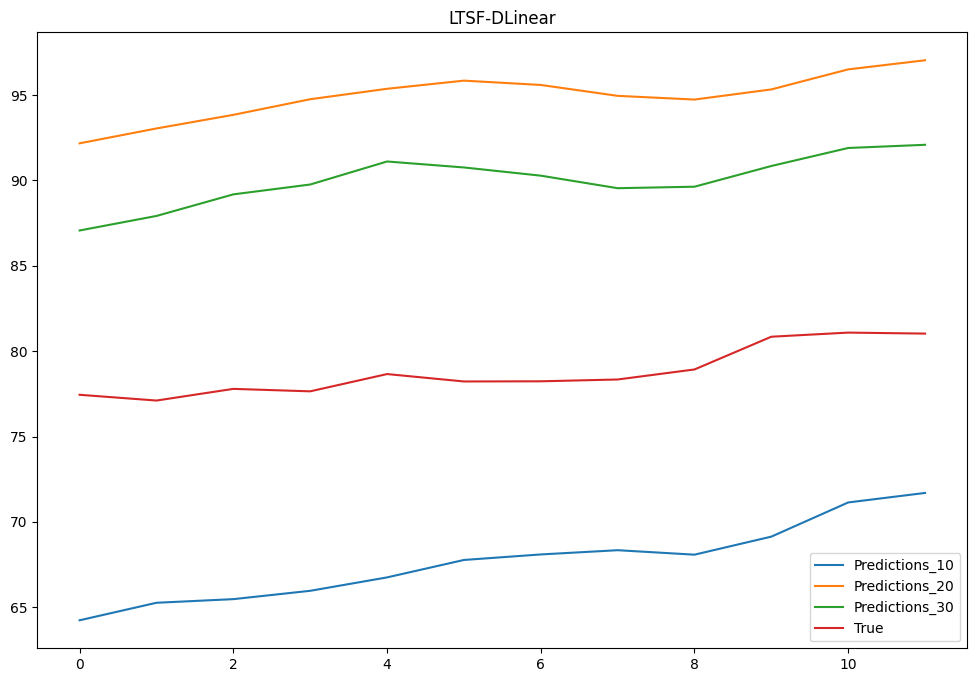

100%|██████████| 93/93 [00:00<00:00, 159.68it/s]


Test Loss: 135.281693
torch.Size([2969, 30, 9])
['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2998, 8)
Successfully added vix
Successfully added turbulence index
Stock Dimension: 9, State Space: 118
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to resultsa2c
--------------------------------------
| time/                 |            |
|    fps                | 234        |
|    iterations         | 100        |
|    time_elapsed       | 2          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -12.8      |
|    explained_variance | -0.0594    |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -30.5      |
|    reward             | 0.24581912 |
|    std            

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


result:                       a2c           dji
date                                  
2021-10-01  1.000000e+06  1.000000e+06
2021-10-04  9.936449e+05  9.905746e+05
2021-10-05  9.957527e+05  9.996566e+05
2021-10-06  9.991440e+05  1.002637e+06
2021-10-07  1.014272e+06  1.012483e+06
2021-10-08  1.009757e+06  1.012229e+06
2021-10-11  1.005805e+06  1.004941e+06
2021-10-12  1.013490e+06  1.001511e+06
2021-10-13  1.018352e+06  1.001496e+06
2021-10-14  1.029049e+06  1.017074e+06
2021-10-15  1.044136e+06  1.028209e+06
2021-10-18  1.056214e+06  1.027155e+06
2021-10-19  1.053354e+06  1.032944e+06
2021-10-20  1.052827e+06  1.037373e+06
2021-10-21  1.067690e+06  1.037190e+06
2021-10-22  1.064307e+06  1.039345e+06
2021-10-25  1.089736e+06  1.041213e+06
2021-10-26  1.090028e+06  1.041671e+06
2021-10-27  1.092148e+06  1.033916e+06
2021-10-28  1.106286e+06  1.040902e+06
2021-10-29  1.109018e+06  1.043497e+06
2021-11-01  1.128727e+06  1.046244e+06
2021-11-02  1.121633e+06  1.050287e+06
2021-11-03  1.14

<Figure size 1500x500 with 0 Axes>

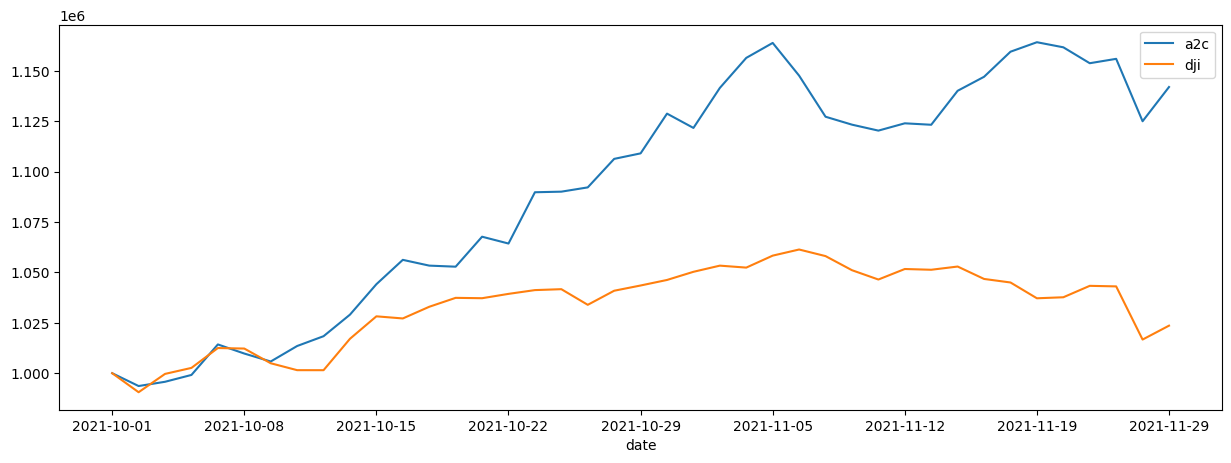

In [16]:
if __name__=="__main__":
  ############# parameter ####################

  TRADE_END_DATE = '2023-05-05' # 수정하면 DLINEAR에도 함께 수정됨

  strategy = ['a2c','ddpg','ppo','td3','sac']
  using = strategy[0]

  ## dlinear parameter
  FORCAST_SIZE = 30
  epochs = 200
  tolerance = 0.0001

  ## env_kwargs
  hmax = 10000
  initial_amount = 1000000
  ############################################

  earning_rate, cash, record = finrl_main(using, TRADE_END_DATE, FORCAST_SIZE, epochs, tolerance, hmax, initial_amount)